In [1]:
import pandas as pd

# Load CSV into dataframe
df = pd.read_csv ('tweets.csv')

In [2]:
df.head()

,tweet_text,created_at,place,context_annotations,city
0,kemana kamu nak alirkan air dari kota kemuning...,2022-01-01 14:33:48+00:00,NaN,"[{'domain': {'id': '66', 'name': 'Interests an...",NaN
1,#DaruratBanjir\r\n#Johor https://t.co/Nxy7oMWwkr,2022-01-01 14:33:26+00:00,NaN,"[{'domain': {'id': '66', 'name': 'Interests an...",NaN
2,"menteri fed &amp; state &amp; exco ,\r\nsement...",2022-01-01 14:31:39+00:00,NaN,"[{'domain': {'id': '66', 'name': 'Interests an...",NaN
3,#DaruratBanjir #BenderaPutih #RakyatJagaRakyat...,2022-01-01 14:22:17+00:00,NaN,"[{'domain': {'id': '66', 'name': 'Interests an...",NaN
4,Bantuan RM2500 untuk membeli barang2 keperluan...,2022-01-01 14:18:25+00:00,NaN,"[{'domain': {'id': '66', 'name': 'Interests an...",NaN


## Most mentioned city in Word Cloud

In [41]:
# Remove empty bracket city
df_city = df[df.city != "[]"]

# Remove empty value city
df_city = df_city.dropna(subset=['city'])

df_city

,tweet_text,created_at,place,context_annotations,city
4370,"OH SELANGORKU! URUS COVID-19 PUN GAGAL, KALI N...",2022-01-06 03:32:02+00:00,NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",['Putrajaya']
4377,Pengumuman Pengiriman Malaysia\r\n\r\nSehubung...,2022-01-06 03:21:57+00:00,NaN,"[{'domain': {'id': '65', 'name': 'Interests an...","['Segamat', 'Tampin']"
4383,YAYASAN AMAN BERHAD MILIK WAN AZIZAH TAK NAK B...,2022-01-06 03:07:11+00:00,NaN,"[{'domain': {'id': '65', 'name': 'Interests an...",['Putrajaya']
4392,"@null 120 ekor lembu hilang, jadi 'mangsa korb...",2022-01-06 03:00:23+00:00,NaN,"[{'domain': {'id': '65', 'name': 'Interests an...",['Segamat']
4397,"OH SELANGORKU! URUS COVID-19 PUN GAGAL, KALI N...",2022-01-06 02:49:58+00:00,NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",['Putrajaya']
...,...,...,...,...,...
5490,"Di Johor, Khidmat Malaysia telah membuka 3 bua...",2022-01-04 00:55:01+00:00,NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...","['Segamat', 'Labis']"
5491,"Alhamdulillah, sebelum pulang ke Putrajaya, sa...",2022-01-04 00:54:59+00:00,NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",['Putrajaya']
5507,"@null Kluang flood victims accept fate, thankf...",2022-01-04 00:20:24+00:00,NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",['Kluang']
5525,KERAJAAN SEDIAKAN BANTUAN PEMBAIKAN &amp; PEMB...,2022-01-03 23:45:00+00:00,NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",['Putrajaya']


In [99]:
# Cleaning city data from "['Putrajaya']" become "Putrajaya" & Add to an empty wc_city list

import re

wc_city_list = []
characters_to_remove = "\[\]\'"
pattern = "[" + characters_to_remove + "]"

for city in df_city['city']:
    wc_city_list.extend(re.sub(pattern, "", city).split(','))

print(wc_city_list)

['Putrajaya', 'Segamat', ' Tampin', 'Putrajaya', 'Segamat', 'Putrajaya', 'Muar', 'Kuala Lumpur', 'Segamat', 'Putrajaya', 'Putrajaya', 'Putrajaya', 'Yong Peng', 'Klang', 'Klang', 'Muar', 'Muar', 'Shah Alam', 'Putrajaya', 'Segamat', 'Klang', 'Kuantan', 'Segamat', 'Segamat', 'Klang', 'Sepang', 'Klang', 'Petaling Jaya', 'Raub', 'Raub', 'Raub', 'Kuala Kedah', 'Segamat', 'Putrajaya', 'Putrajaya', 'Klang', 'Shah Alam', 'Segamat', 'Shah Alam', ' Kuantan', 'Shah Alam', 'Petaling Jaya', ' Sepang', ' Kuala Selangor', 'Putrajaya', 'Putrajaya', 'Kuala Lumpur', 'Putrajaya', 'Segamat', 'Segamat', 'Segamat', 'Kluang', 'Putrajaya', 'Seremban', 'Putrajaya', 'Yong Peng', 'Putrajaya', 'Kuala Lumpur', 'Muar', 'Segamat', 'Pekan', 'Raub', ' Pekan', ' Kuala Lipis', 'Batu Berendam', 'Segamat', 'Paka', 'Banting', ' Mersing', 'Kuala Lipis', 'Shah Alam', 'Kuala Lumpur', ' Putrajaya', 'Klang', 'Kuantan', ' Raub', ' Jerantut', 'Segamat', 'Johor Bahru', ' Kluang', 'Putrajaya', 'Kuala Lipis', 'Johor Bahru', 'Segamat'

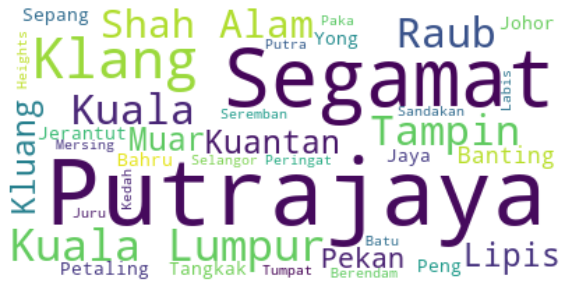

In [98]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc_city = (" ").join(wc_city_list)
wordcloud = WordCloud(background_color="white", repeat=False).generate(wc_city_string)

# Display the generated image:
plt.figure(figsize=(10,10)) #inches
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

plt.show()

## Count of flood-related hashtag against time line graph

In [ ]:
# Split timestamp into date and timestamp
timestamp = df["created_at"].str.split(" ", n = 1, expand = True)
df["date"] = pd.to_datetime(timestamp[0])
df["time"] = timestamp[1]

In [ ]:
# Group the tweets by date into new dataframe
df_count = df.groupby(df.date.dt.floor('1D')).count()
df_count

In [ ]:
# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(df_count.tweet_text, color='tab:blue', label='Count')

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Flood-related Tweets')
ax.grid(True)
ax.legend(loc='upper left');